In [0]:
# sklearn analytics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score

# Models
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression



# General
import warnings
import numpy as np
import pandas as pd
import random
import os
import re
import string
import statsmodels.api as sm
from os import path
from PIL import Image
from time import time
from sklearn import utils

# Warnings
warnings.filterwarnings('ignore')

In [0]:
# Read and Peak at Data
df = pd.read_csv(
    'https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/customers_data.csv')

df.head()

,Unnamed: 0,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,0,19.58,male,no,31.0,35.0,False
1,1,65.16,male,yes,23.0,61.0,False
2,2,40.60,female,no,36.0,49.0,False
3,3,38.01,male,yes,47.0,57.0,False
4,4,22.32,female,yes,5.0,39.0,False


## The Data

*   Unnamed: 0 is a duplicate index column, so I can drop that.
*   purch_amt, card_on_file, and days_since_last_purch are all continuous floats.
*   gender, card_on_file, and loyalty are all discrete categorical variables.

We want to replace the categorical variables with binary placeholders to make analysis easier, and drop the repeat index column. 

**The goal is to see if we can predict whether someone is a loyalty member.**

In [0]:
# Functions to binarize categoricals
def binary_gender(gender):
    if gender == 'female':
        return 0
    else:
        return 1

def binary_card(card_on_file):
    if card_on_file == 'no':
        return 0
    else:
        return 1
      
def binary_loyalty(loyalty):
    if loyalty == False:
        return 0
    else:
        return 1      

      #drop nulls
df = df.dropna()

# Apply binary functions
df['gender_recode'] = df['gender'].apply(binary_gender)
df['card_recode'] = df['card_on_file'].apply(binary_card)
df['loyalty_recode'] = df['loyalty'].apply(binary_loyalty)

#drop clutter columns
df = df.drop(['Unnamed: 0', 'gender', 'card_on_file', 'loyalty' ], 
             axis='columns')
df.head()

,purch_amt,age,days_since_last_purch,gender_recode,card_recode,loyalty_recode
0,19.58,31.0,35.0,1,0,0
1,65.16,23.0,61.0,1,1,0
2,40.60,36.0,49.0,0,0,0
3,38.01,47.0,57.0,1,1,0
4,22.32,5.0,39.0,0,1,0


In [0]:
df.describe()

,purch_amt,age,days_since_last_purch,gender_recode,card_recode,loyalty_recode
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,44.036234,25.803008,56.605908,0.501508,0.500725,0.166667
std,20.473148,10.153072,16.422187,0.500000,0.500002,0.372680
min,-43.950000,-22.000000,-9.000000,0.000000,0.000000,0.000000
25%,30.210000,19.000000,45.000000,0.000000,0.000000,0.000000
50%,43.970000,26.000000,57.000000,1.000000,1.000000,0.000000
75%,57.830000,33.000000,68.000000,1.000000,1.000000,0.000000
max,142.200000,71.000000,125.000000,1.000000,1.000000,1.000000


Running a quick describe revealed some interesting problems, namely that I have negative values in columns that shouldn’t have less than zero. 

I also noticed “age” had a lot of children, which considering we are looking at sales and loyalty memberships, I assume are errors. I'm going to drop values less than zero in “purch_amt” and “days_since_last_purch” as well as values less than 13 in “age”.

In [0]:
df = df[df['purch_amt'] > 0]
df = df[df['age'] > 13]
df = df[df['days_since_last_purch'] > 0]
df.describe()

,purch_amt,age,days_since_last_purch,gender_recode,card_recode,loyalty_recode
count,104861.000000,104861.000000,104861.000000,104861.000000,104861.000000,104861.000000
mean,44.968775,27.990244,56.330743,0.502541,0.499728,0.179876
std,19.628377,8.464575,16.475841,0.499996,0.500002,0.384086
min,0.010000,14.000000,1.000000,0.000000,0.000000,0.000000
25%,31.090000,21.000000,45.000000,0.000000,0.000000,0.000000
50%,44.530000,27.000000,57.000000,1.000000,0.000000,0.000000
75%,58.230000,34.000000,68.000000,1.000000,1.000000,0.000000
max,142.200000,71.000000,125.000000,1.000000,1.000000,1.000000


In [0]:
df.columns

Index(['purch_amt', 'age', 'days_since_last_purch', 'gender_recode',
       'card_recode', 'loyalty_recode'],
      dtype='object')

# **EDA**

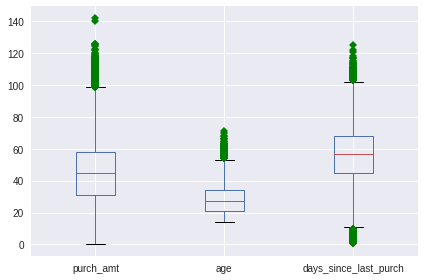

In [0]:
# Checking for outliers in the continuous variables
green_diamond = dict(markerfacecolor='g', marker='D')
boxplot = df.boxplot(column=['purch_amt', 'age', 'days_since_last_purch'], 
                     showfliers=True, flierprops=green_diamond)
plt.tight_layout()

We want to remove outliers, but retain information. I'll do so using 3 standard deviations as a cut off. This retains 99.73% of the sample variance.

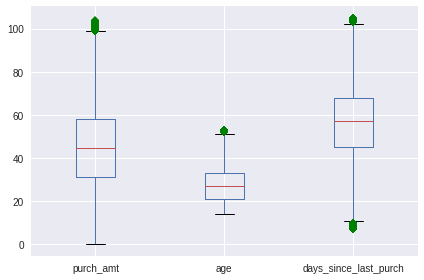

In [0]:
# Code to remove outliers
df = df[np.abs(df.purch_amt-df.purch_amt.mean()) <= (3*df.purch_amt.std())]
df = df[np.abs(df.age-df.age.mean()) <= (3*df.age.std())]
df = df[np.abs(
    df.days_since_last_purch-df.days_since_last_purch.mean(
    )) <= (3*df.days_since_last_purch.std())]

# Checking for outliers in the continuous variables
green_diamond = dict(markerfacecolor='g', marker='D')
boxplot = df.boxplot(column=['purch_amt', 'age', 'days_since_last_purch'], 
                     showfliers=True, flierprops=green_diamond)
plt.tight_layout()

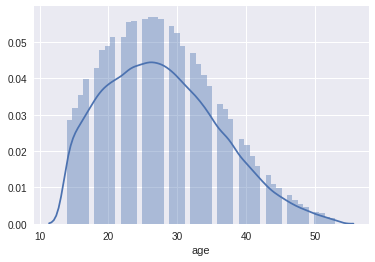

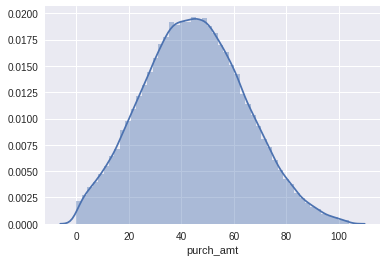

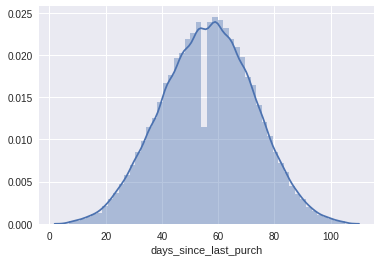

In [0]:
#Examining the distributions of continuous variables 
sns.distplot(df.age)
plt.show()
sns.distplot(df.purch_amt)
plt.show()
sns.distplot(df.days_since_last_purch)
plt.show()

                       purch_amt       age  days_since_last_purch  \
purch_amt               1.000000  0.033609              -0.099118   
age                     0.033609  1.000000              -0.076349   
days_since_last_purch  -0.099118 -0.076349               1.000000   
gender_recode          -0.000840  0.006342               0.000650   
card_recode             0.000058  0.000708               0.001335   
loyalty_recode          0.214544  0.162350              -0.466053   

                       gender_recode  card_recode  loyalty_recode  
purch_amt                  -0.000840     0.000058        0.214544  
age                         0.006342     0.000708        0.162350  
days_since_last_purch       0.000650     0.001335       -0.466053  
gender_recode               1.000000    -0.003223        0.001987  
card_recode                -0.003223     1.000000       -0.000332  
loyalty_recode              0.001987    -0.000332        1.000000  


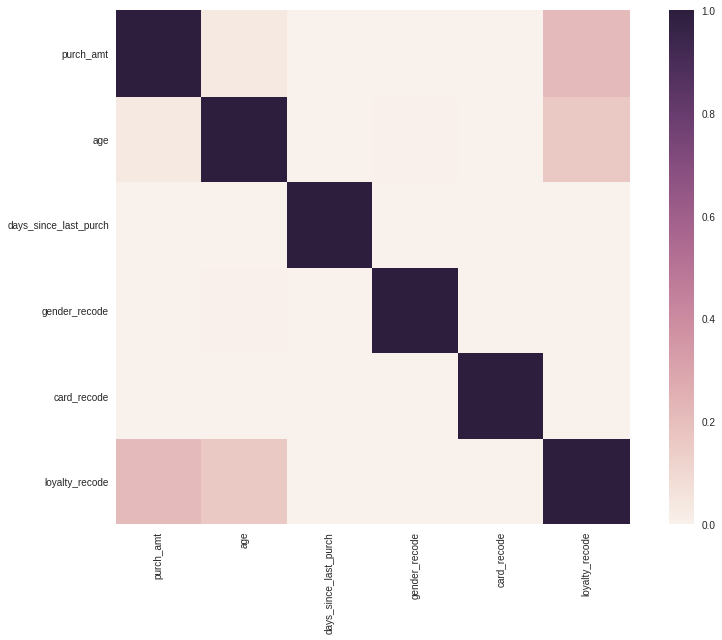

In [0]:
# Making a correlation matrix to examine correlation.
corrmat = df.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=1, vmin=0, square=True)
plt.tight_layout()
#plt.savefig('CorrMat both Sexs.png', dpi=300)
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


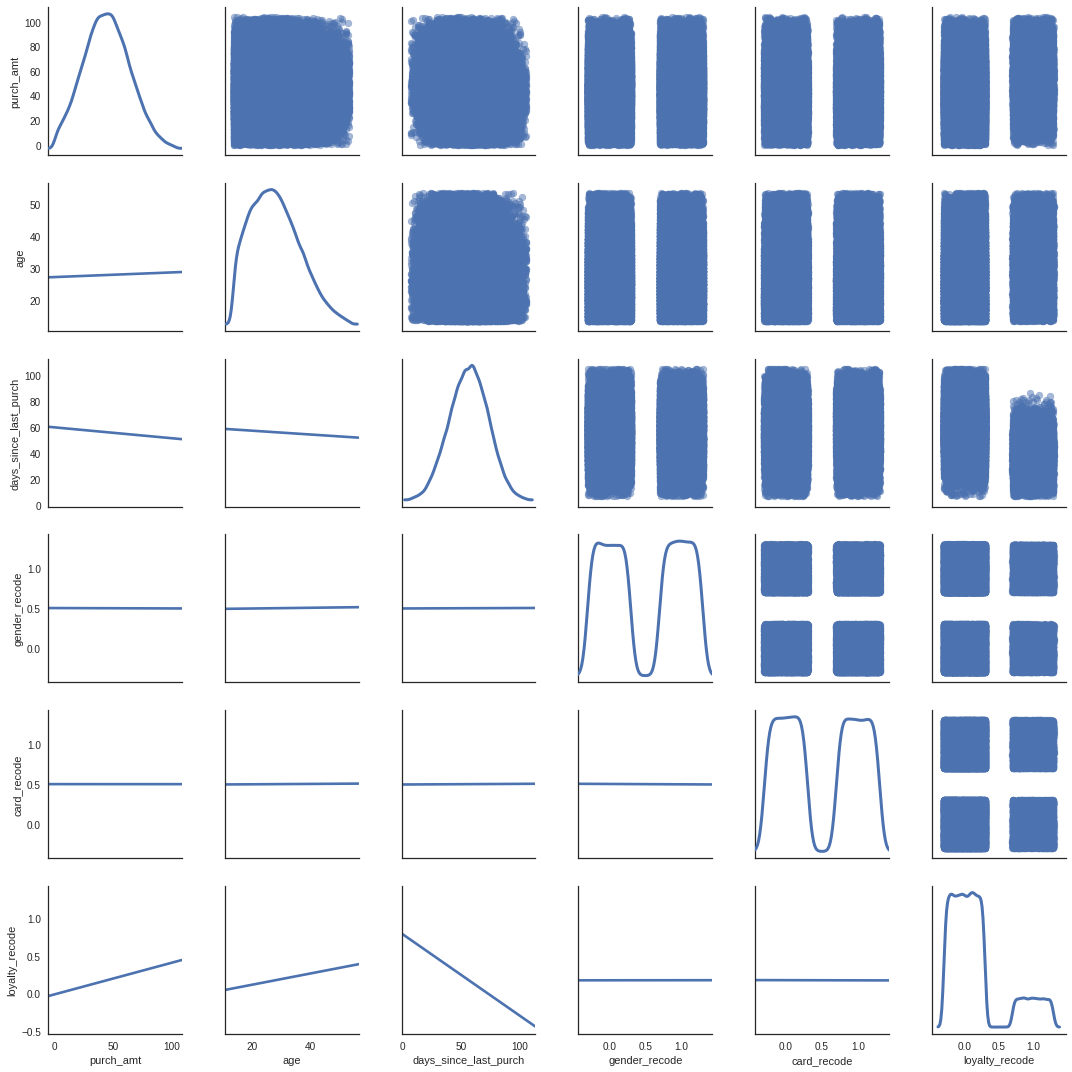

In [0]:
# Making a scatterplot matrix to investigate 

# Set the default plot aesthetics to be prettier.
sns.set_style("white")

# Make a copy of the data to add jitter to and plot.
df_jittered = df.loc[:,  'purch_amt':'loyalty_recode'].dropna()

# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(df_jittered.shape)),
    columns=df_jittered.columns
)
# Combine the data and the noise.
df_jittered = df_jittered.add(jitter)

# Make a scatterplot matrix.
g = sns.PairGrid(df_jittered.dropna(), diag_sharey=False)

# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)

# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.tight_layout()
#plt.savefig('Scatterplt both Sexs.png', dpi=200)
plt.show()

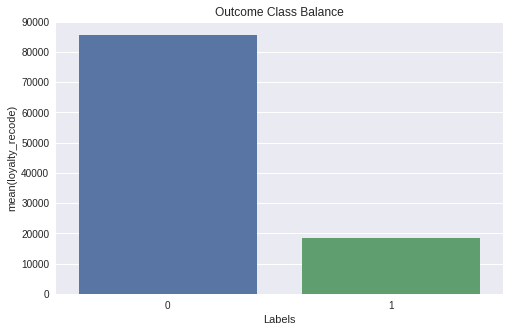

In [0]:
# Plot the label classes
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.loyalty_recode.unique(),
                 y=df.loyalty_recode.value_counts());
ax.set(xlabel='Labels')
ax.set_title('Outcome Class Balance')
plt.show()

# **Addressing class imbalance**

I have imbalanced data.

I could normalize the distribution and rerun everything, or I could either downsample or upsample the data from where I'm at. Rather than downsample the majority class I'm going to upsample the minority class. To do this I'll use the Synthetic Minority Oversampling Technique (SMOTE) from the imbalanced-learn library.

In [0]:
# Import the hopeful solution to our problems
from imblearn.over_sampling import SMOTE
smote = SMOTE()

#Defining X and Y
X = df.loc[:, (df.columns != 'loyalty_recode')]
y = df['loyalty_recode']

# Setting up new balanced variables for ML
X_sm, y_sm = smote.fit_sample(X, y)

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(
    X_sm, y_sm, test_size=0.2, random_state=42)

In [0]:
# Defining a function to fit and predict ML algorithms
def auto_model(mod, model_name, X_train, X_test, y_train, y_test):
    t0 = time()
    mod.fit(X_train, y_train)
    print(model_name)
    print("done in %0.3fs" % (time() - t0))
    acc = cross_val_score(mod, X_train, y_train,
                          scoring="accuracy", cv=5)
    predictions = cross_val_predict(mod, X_train, y_train, cv=5)
    print("Accuracy:", round(acc.mean(), 3))
    cm = pd.crosstab(y_train, predictions, rownames=['True'], 
                 colnames=['Predicted'], margins=True)
    print("\nConfusion Matrix:  \n", cm)
    print("\n                    Classification Report \n",
          classification_report(y_train, predictions))

I'll compare 4 binary classification models using my auto_model function.

# **SMOTE Train/ Test Split Classification**

In [0]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
auto_model(rfc, "Random Forest Classifier",
           X_train_sm, X_test_sm, y_train_sm, y_test_sm)

Random Forest Classifier
done in 14.597s
Accuracy: 0.898

Confusion Matrix:  
 Predicted      0      1     All
True                           
0          62114   6536   68650
1           7428  60861   68289
All        69542  67397  136939

                    Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.90      0.90     68650
           1       0.90      0.89      0.90     68289

   micro avg       0.90      0.90      0.90    136939
   macro avg       0.90      0.90      0.90    136939
weighted avg       0.90      0.90      0.90    136939



In [0]:
# Gaussian Naive Bayes
gnb = GaussianNB()
auto_model(gnb, "Gaussian Naive Bayes", 
              X_train_sm, X_test_sm, y_train_sm, y_test_sm)

Gaussian Naive Bayes
done in 0.044s
Accuracy: 0.797

Confusion Matrix:  
 Predicted      0      1     All
True                           
0          53187  15463   68650
1          12328  55961   68289
All        65515  71424  136939

                    Classification Report 
               precision    recall  f1-score   support

           0       0.81      0.77      0.79     68650
           1       0.78      0.82      0.80     68289

   micro avg       0.80      0.80      0.80    136939
   macro avg       0.80      0.80      0.80    136939
weighted avg       0.80      0.80      0.80    136939



In [0]:
# Logistic Regression
log = LogisticRegression(solver='lbfgs')
auto_model(log, "Logistic Regression", 
           X_train_sm, X_test_sm, y_train_sm, y_test_sm)

Logistic Regression
done in 0.819s
Accuracy: 0.792

Confusion Matrix:  
 Predicted      0      1     All
True                           
0          53910  14740   68650
1          13715  54574   68289
All        67625  69314  136939

                    Classification Report 
               precision    recall  f1-score   support

           0       0.80      0.79      0.79     68650
           1       0.79      0.80      0.79     68289

   micro avg       0.79      0.79      0.79    136939
   macro avg       0.79      0.79      0.79    136939
weighted avg       0.79      0.79      0.79    136939



In [0]:
# Linear SVC
svc = LinearSVC(dual=False)
auto_model(svc, "Linear SVC", X_train_sm, X_test_sm, y_train_sm, y_test_sm)

Linear SVC
done in 0.242s
Accuracy: 0.792

Confusion Matrix:  
 Predicted      0      1     All
True                           
0          53815  14835   68650
1          13630  54659   68289
All        67445  69494  136939

                    Classification Report 
               precision    recall  f1-score   support

           0       0.80      0.78      0.79     68650
           1       0.79      0.80      0.79     68289

   micro avg       0.79      0.79      0.79    136939
   macro avg       0.79      0.79      0.79    136939
weighted avg       0.79      0.79      0.79    136939



We can investigate whether PCA improves performance. 

# **PCA Classification**

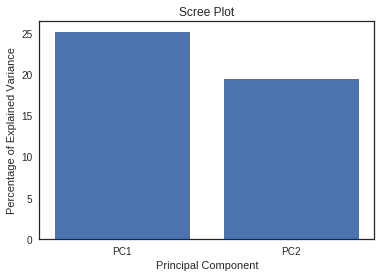

In [0]:
# PCA from 5 features to 2 PCs
from sklearn.decomposition import PCA
from sklearn import preprocessing

X_scaled = pd.DataFrame(preprocessing.scale(
    X), index=X.index, columns=X.columns)

X_scaled_sm, y_sm2 = smote.fit_sample(X_scaled, y)

X_scaled_df = pd.DataFrame(X_scaled_sm, columns=X.columns)

pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled_sm)
principalDf = pd.DataFrame(data=pc)

# The following code constructs the Scree plot
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

In [0]:
# Defining X_pc for PCA output
X_pca = pc[:, 0:2]


# Creating my training data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y_sm, test_size=0.2, random_state=42)

In [0]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
auto_model(rfc, "Random Forest Classifier",
           X_train_pca, X_test_pca, y_train_pca, y_test_pca)

Random Forest Classifier
done in 24.504s
Accuracy: 0.768

Confusion Matrix:  
 Predicted      0      1     All
True                           
0          51793  16857   68650
1          15040  53249   68289
All        66833  70106  136939

                    Classification Report 
               precision    recall  f1-score   support

           0       0.77      0.75      0.76     68650
           1       0.76      0.78      0.77     68289

   micro avg       0.77      0.77      0.77    136939
   macro avg       0.77      0.77      0.77    136939
weighted avg       0.77      0.77      0.77    136939



In [0]:
# Gaussian Naive Bayes
gnb = GaussianNB()
auto_model(gnb, "Gaussian Naive Bayes", 
              X_train_pca, X_test_pca, y_train_pca, y_test_pca)

Gaussian Naive Bayes
done in 0.029s
Accuracy: 0.765

Confusion Matrix:  
 Predicted      0      1     All
True                           
0          51996  16654   68650
1          15561  52728   68289
All        67557  69382  136939

                    Classification Report 
               precision    recall  f1-score   support

           0       0.77      0.76      0.76     68650
           1       0.76      0.77      0.77     68289

   micro avg       0.76      0.76      0.76    136939
   macro avg       0.76      0.76      0.76    136939
weighted avg       0.76      0.76      0.76    136939



In [0]:
# Logistic Regression
log = LogisticRegression(solver='lbfgs')
auto_model(log, "Logistic Regression", 
           X_train_pca, X_test_pca, y_train_pca, y_test_pca)

Logistic Regression
done in 0.148s
Accuracy: 0.764

Confusion Matrix:  
 Predicted      0      1     All
True                           
0          52414  16236   68650
1          16036  52253   68289
All        68450  68489  136939

                    Classification Report 
               precision    recall  f1-score   support

           0       0.77      0.76      0.76     68650
           1       0.76      0.77      0.76     68289

   micro avg       0.76      0.76      0.76    136939
   macro avg       0.76      0.76      0.76    136939
weighted avg       0.76      0.76      0.76    136939



In [0]:
# Linear SVC
svc = LinearSVC()
auto_model(svc, "Linear SVC", 
           X_train_pca, X_test_pca, y_train_pca, y_test_pca)

Linear SVC
done in 3.629s
Accuracy: 0.764

Confusion Matrix:  
 Predicted      0      1     All
True                           
0          52395  16255   68650
1          16010  52279   68289
All        68405  68534  136939

                    Classification Report 
               precision    recall  f1-score   support

           0       0.77      0.76      0.76     68650
           1       0.76      0.77      0.76     68289

   micro avg       0.76      0.76      0.76    136939
   macro avg       0.76      0.76      0.76    136939
weighted avg       0.76      0.76      0.76    136939



PCA did not improve on our previous models.

We can investigate if variance threshold performs better. 

# **Variance Threshold Classification**

In [0]:
from sklearn.feature_selection import VarianceThreshold


def variance_threshold_selector(data, threshold):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [0]:
variance_threshold = variance_threshold_selector(
    X_scaled_df, threshold=(.8 * (1 - .8)))

# Creating my training data
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    variance_threshold, y_sm, test_size=0.2, random_state=42)

In [0]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
auto_model(rfc, "Random Forest Classifier",
           X_train1, X_test1, y_train1, y_test1)

Random Forest Classifier
done in 17.400s
Accuracy: 0.888

Confusion Matrix:  
 Predicted      0      1     All
True                           
0          60101   8549   68650
1           6784  61505   68289
All        66885  70054  136939

                    Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.88      0.89     68650
           1       0.88      0.90      0.89     68289

   micro avg       0.89      0.89      0.89    136939
   macro avg       0.89      0.89      0.89    136939
weighted avg       0.89      0.89      0.89    136939



In [0]:
# Gaussian Naive Bayes
gnb = GaussianNB()
auto_model(gnb, "Gaussian Naive Bayes", 
              X_train1, X_test1, y_train1, y_test1)

Gaussian Naive Bayes
done in 0.038s
Accuracy: 0.795

Confusion Matrix:  
 Predicted      0      1     All
True                           
0          52787  15863   68650
1          12267  56022   68289
All        65054  71885  136939

                    Classification Report 
               precision    recall  f1-score   support

           0       0.81      0.77      0.79     68650
           1       0.78      0.82      0.80     68289

   micro avg       0.79      0.79      0.79    136939
   macro avg       0.80      0.79      0.79    136939
weighted avg       0.80      0.79      0.79    136939



In [0]:
# Logistic Regression
log = LogisticRegression(solver='lbfgs')
auto_model(log, "Logistic Regression", X_train1, X_test1, y_train1, y_test1)

Logistic Regression
done in 0.188s
Accuracy: 0.794

Confusion Matrix:  
 Predicted      0      1     All
True                           
0          53913  14737   68650
1          13528  54761   68289
All        67441  69498  136939

                    Classification Report 
               precision    recall  f1-score   support

           0       0.80      0.79      0.79     68650
           1       0.79      0.80      0.79     68289

   micro avg       0.79      0.79      0.79    136939
   macro avg       0.79      0.79      0.79    136939
weighted avg       0.79      0.79      0.79    136939



In [0]:
# Linear SVC
svc = LinearSVC()
auto_model(svc, "Linear SVC", X_train1, X_test1, y_train1, y_test1)

Linear SVC
done in 6.047s
Accuracy: 0.794

Confusion Matrix:  
 Predicted      0      1     All
True                           
0          53798  14852   68650
1          13399  54890   68289
All        67197  69742  136939

                    Classification Report 
               precision    recall  f1-score   support

           0       0.80      0.78      0.79     68650
           1       0.79      0.80      0.80     68289

   micro avg       0.79      0.79      0.79    136939
   macro avg       0.79      0.79      0.79    136939
weighted avg       0.79      0.79      0.79    136939



Lastly let's examine training random forest without a training holdback.

# **Random Forest Without Hold BAck**

In [0]:
# Defining cross-validation parameters.
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

rfc = RandomForestClassifier(n_estimators=100, 
                             n_jobs=-1)
rfcfit = rfc.fit(X_sm, y_sm)


print('R² for the RF model: \n', rfcfit.score(X_sm, y_sm))
print('Accuracy Score: \n', rfcfit.score(X_sm, y_sm))
score = cross_val_score(rfcfit, X_sm, y_sm, cv=cv)
print("\nMean (SD) Cross Validation Score: %0.2f (+/- %0.2f)" %
      (score.mean(), score.std() * 2))
print('\nCross Validation Scores: \n', score)


# Extract predicted values.
predicted = rfcfit.predict(X_sm)
actual = y_sm

cm = pd.crosstab(y_sm, predicted, rownames=['True'], 
             colnames=['Predicted'], margins=True)
print("\nConfusion Matrix:  \n", cm)
print("\n                    Classification Report \n",
      classification_report(y_sm, predicted))

R² for the RF model: 
 0.9998422657646605
Accuracy Score: 
 0.9998422657646605

Mean (SD) Cross Validation Score: 0.90 (+/- 0.00)

Cross Validation Scores: 
 [0.90167957 0.90436688 0.90156273 0.90173799 0.90092011]

Confusion Matrix:  
 Predicted      0      1     All
True                           
0          85581      6   85587
1             21  85566   85587
All        85602  85572  171174

                    Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85587
           1       1.00      1.00      1.00     85587

   micro avg       1.00      1.00      1.00    171174
   macro avg       1.00      1.00      1.00    171174
weighted avg       1.00      1.00      1.00    171174



This looks pretty good, but definitely overfit. Let's see if we can improve it any by tuning hyperparameters. 

In [0]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 100],
    'min_samples_leaf': [3, 10],
    'min_samples_split': [2, 12],
    'n_estimators': [100, 300]
}

In [0]:
# Instantiate the grid search model
n_jobs=4

grid_search = GridSearchCV(estimator=rfcfit, param_grid=param_grid,
                           cv=3, n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_sm, y_sm)
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 100,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

In [0]:
# Defining cross-validation parameters.
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

rfc = RandomForestClassifier(n_estimators=100, max_depth=100, 
                             min_samples_leaf=3,                 
                             min_samples_split=2, n_jobs=-1)
rfcfit = rfc.fit(X_sm, y_sm)


print('R² for the RF model: \n', rfcfit.score(X_sm, y_sm))
print('Accuracy Score: \n', rfcfit.score(X_sm, y_sm))
score = cross_val_score(rfcfit, X_sm, y_sm, cv=cv)
print("\nMean (SD) Cross Validation Score: %0.2f (+/- %0.2f)" %
      (score.mean(), score.std() * 2))
print('\nCross Validation Scores: \n', score)


# Extract predicted values.
predicted = rfcfit.predict(X_sm)
actual = y_sm

cm = pd.crosstab(y_sm, predicted, rownames=['True'], 
             colnames=['Predicted'], margins=True)
print("\nConfusion Matrix:  \n", cm)
print("\n                    Classification Report \n",
      classification_report(y_sm, predicted))

R² for the RF model: 
 0.9570670779440803
Accuracy Score: 
 0.9570670779440803

Mean (SD) Cross Validation Score: 0.90 (+/- 0.00)

Cross Validation Scores: 
 [0.8973273  0.90013144 0.89913831 0.8999854  0.8985249 ]

Confusion Matrix:  
 Predicted      0      1     All
True                           
0          82818   2769   85587
1           4580  81007   85587
All        87398  83776  171174

                    Classification Report 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     85587
           1       0.97      0.95      0.96     85587

   micro avg       0.96      0.96      0.96    171174
   macro avg       0.96      0.96      0.96    171174
weighted avg       0.96      0.96      0.96    171174



The tuned model is less overfit and retains the same cross val.

Let's also verify SMOTE is heping here.


In [0]:
# Defining cross-validation parameters.
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)


rfcfit2 = rfc.fit(X, y)


print('R² for the RF model: \n', rfcfit2.score(X, y))
print('Accuracy Score: \n', rfcfit2.score(X, y))
score = cross_val_score(rfcfit2, X, y, cv=cv)
print("\nMean (SD) Cross Validation Score: %0.2f (+/- %0.2f)" %
      (score.mean(), score.std() * 2))
print('\nCross Validation Scores: \n', score)


# Extract predicted values.
predicted = rfcfit2.predict(X)
actual = y

cm = pd.crosstab(y, predicted, rownames=['True'], 
             colnames=['Predicted'], margins=True)
print("\nConfusion Matrix:  \n", cm)
print("\n                    Classification Report \n",
      classification_report(y, predicted))

R² for the RF model: 
 0.9997886363199662
Accuracy Score: 
 0.9997886363199662

Mean (SD) Cross Validation Score: 0.84 (+/- 0.00)

Cross Validation Scores: 
 [0.84114708 0.84345278 0.84172351 0.84138726 0.84268422]

Confusion Matrix:  
 Predicted      0      1     All
True                           
0          85584      3   85587
1             19  18480   18499
All        85603  18483  104086

                    Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85587
           1       1.00      1.00      1.00     18499

   micro avg       1.00      1.00      1.00    104086
   macro avg       1.00      1.00      1.00    104086
weighted avg       1.00      1.00      1.00    104086



SMOTE  helps!

Let's try some hyperparameter tuning for this model. 

In [0]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 100],
    'min_samples_leaf': [3, 10],
    'min_samples_split': [2, 12],
    'n_estimators': [100, 300]
}

In [0]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfcfit2, param_grid=param_grid,
                           cv=3, n_jobs=4, pre_dispatch=2*n_jobs)
grid_search.fit(X, y)
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 300}

In [0]:
# Defining cross-validation parameters.
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

rfc = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=3,                 
                             min_samples_split=2, n_jobs=-1)
rfcfit2 = rfc.fit(X, y)


print('R² for the RF model: \n', rfcfit2.score(X, y))
print('Accuracy Score: \n', rfcfit2.score(X, y))
score = cross_val_score(rfcfit2, X, y, cv=cv)
print("\nMean (SD) Cross Validation Score: %0.2f (+/- %0.2f)" %
      (score.mean(), score.std() * 2))
print('\nCross Validation Scores: \n', score)


# Extract predicted values.
predicted = rfcfit2.predict(X)
actual = y

cm = pd.crosstab(y, predicted, rownames=['True'], 
             colnames=['Predicted'], margins=True)
print("\nConfusion Matrix:  \n", cm)
print("\n                    Classification Report \n",
      classification_report(y, predicted))

R² for the RF model: 
 0.8706838575793094
Accuracy Score: 
 0.8706838575793094

Mean (SD) Cross Validation Score: 0.86 (+/- 0.00)

Cross Validation Scores: 
 [0.85824767 0.86122586 0.86199443 0.86016908 0.86069747]

Confusion Matrix:  
 Predicted      0      1     All
True                           
0          82346   3241   85587
1          10219   8280   18499
All        92565  11521  104086

                    Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.96      0.92     85587
           1       0.72      0.45      0.55     18499

   micro avg       0.87      0.87      0.87    104086
   macro avg       0.80      0.70      0.74    104086
weighted avg       0.86      0.87      0.86    104086



This model performed worse even after tuning.

# **Validating the Tuned SMOTE Random Forest**

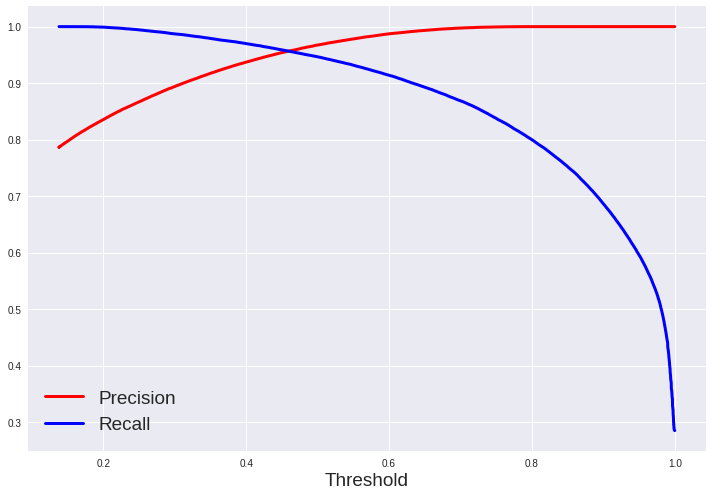

In [0]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=100, 
                             min_samples_leaf=3,                 
                             min_samples_split=2, n_jobs=-1)
rfcfit = rfc.fit(X_sm, y_sm)

# Getting prediction probabilities
y_scores = rfc.predict_proba(X_sm)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_sm, y_scores)

# Defining a new function to plot the precision-recall curve
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="Precision", linewidth=3)
    plt.plot(threshold, recall[:-1], "b", label="Recall", linewidth=3)
    plt.xlabel("Threshold", fontsize=19)
    plt.legend(loc="lower left", fontsize=19)

plt.figure(figsize=(10, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.tight_layout()
plt.show()

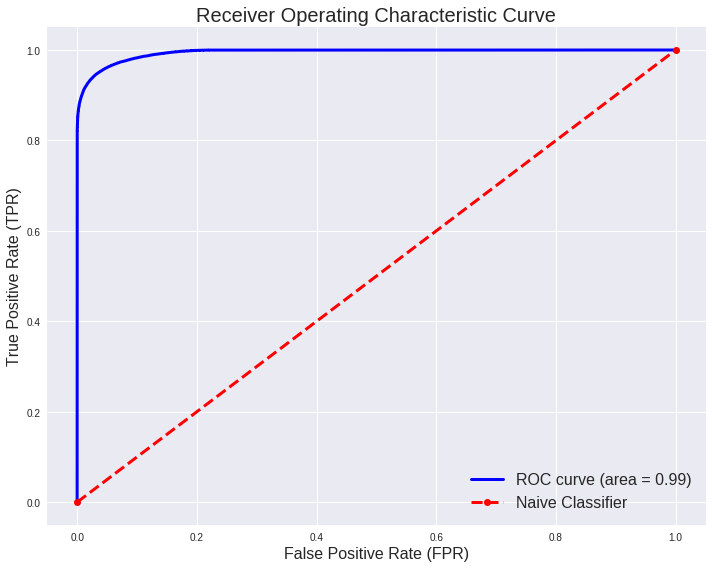

In [0]:
# Compute the true positive and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(
    y_sm, y_scores)

# Plotting the true positive and false positive rate
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             linewidth=3, label='ROC curve (area = {0:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'ro--', label='Naive Classifier',
             linewidth=3)
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)
    plt.legend(loc="lower right", fontsize=16)

plt.figure(figsize=(10, 8))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic Curve', size = 20)
plt.tight_layout()
plt.show()

Given the accuracy of 95%, the F1-scores of 0.96 for both precision and recall, the mean (SD) cross-validation score of 0.90 (<.01) and the area under the ROC Curve = 0.99 I feel confident this model is less overfit thanks to the hyperparameter tuning.  